In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Introduction to MPI and `mpi4py`

### Installation

```
conda install -c conda-forge mpi4py
```
(The standard Anaconda channel for mpi4py is [broken](https://github.com/conda/conda/issues/2277). It is necessary to use the [conda-forge](https://conda-forge.github.io/) channel instead.)

### Example

----
# Digit classification with `mpi4py`

## On two processes

In [2]:
%%file parallel_script.py

from classification import nearest_neighbor_prediction
import numpy as np
from mpi4py.MPI import COMM_WORLD as communicator

# Load data
train_images = np.load('./data/train_images.npy')
train_labels = np.load('./data/train_labels.npy')
test_images = np.load('./data/test_images.npy')

# Use only the data that this rank needs
N_test = len(test_images)
if communicator.rank == 0:
    i_start = 0
    i_end = N_test/2
elif communicator.rank == 1:
    i_start = N_test/2
    i_end = N_test    
small_test_images = test_images[i_start:i_end]

# Predict the results and gather it on rank 0
small_test_labels = nearest_neighbor_prediction(small_test_images, train_images, train_labels)
test_labels_list = communicator.gather( small_test_labels, root=0 )

# Rank 0 merges the results into one array and saves them to a file
if communicator.rank == 0:
    test_labels = np.hstack( test_labels_list )
    np.save('./data/test_labels_parallel.npy', test_labels )

Overwriting parallel_script.py


In [3]:
%%time
! mpirun -np 2 python parallel_script.py

CPU times: user 130 ms, sys: 38.6 ms, total: 168 ms
Wall time: 7.73 s


## On more processes

In [ ]:
import numpy as np

In [ ]:
# Load and split the set of test images
test_images = np.load('data/test_images.npy')
split_arrays = np.array_split( test_images, 4 )

# Print the corresponding shape
print( 'Shape of the original array:' )
print( test_images.shape )
print('Shape of the splitted arrays:')
for array in split_arrays:
    print( array.shape )

In [4]:
%%file parallel_script.py

from classification import nearest_neighbor_prediction
import numpy as np
from mpi4py.MPI import COMM_WORLD as communicator

# Load data
train_images = np.load('./data/train_images.npy')
train_labels = np.load('./data/train_labels.npy')
test_images = np.load('./data/test_images.npy')

# Split the data
# Select the array that is relevant for this rank
split_arrays = np.array_split( test_images, communicator.size )
small_test_images = split_arrays[ communicator.rank ]

# Predict the results and gather it on rank 0
small_test_labels = nearest_neighbor_prediction(small_test_images, train_images, train_labels)
test_labels_list = communicator.gather( small_test_labels, root=0 )

# Rank 0 merges the results into one array and saves them to a file
if communicator.rank == 0:
    test_labels = np.hstack( test_labels_list )
    np.save('./data/test_labels_parallel.npy', test_labels )

Overwriting parallel_script.py


In [5]:
%%time
! mpirun -np 4 python parallel_script.py

CPU times: user 97 ms, sys: 28.7 ms, total: 126 ms
Wall time: 6.1 s


---
# Check the results

In [17]:
# Load the data from the file
test_images = np.load('data/test_images.npy')
test_labels_parallel = np.load('data/test_labels_parallel.npy')

# Define function to have a look at the data
def show_random_digit( images, labels=None ):
    """"Show a random image out of `images`, 
    with the corresponding label if available"""
    i = np.random.randint(len(images))
    image = images[i].reshape((28, 28))
    plt.imshow( image, cmap='Greys' )
    if labels is not None:
        plt.title('Label: %d' %labels[i])

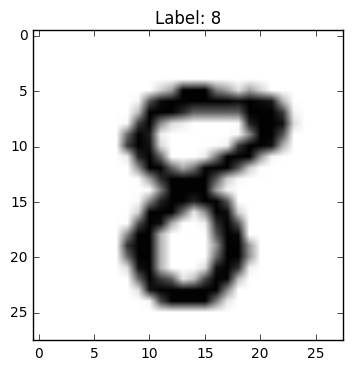

In [21]:
show_random_digit( test_images, test_labels_parallel )